In [1]:
#General libraries
import os, argparse
import pickle

import numpy as np

#Torch libraries
import torch 
from torch import nn

#Custom libraries
from utils import Train_val_split, Dynamics_Dataset, Test_Dynamics_Dataset
from utils import fix_random_seeds,to_np
import IE_source.kernels as kernels
from IE_source.experiments import Full_experiment_AttentionalIE_PDE, Full_experiment_AttentionalIE_PDE_Navier_Stokes
from torch.utils.data import SubsetRandomSampler
from IE_source.kernels import model_blocks

from IE_source.Attentional_IE_solver import masking_function, Integral_attention_solver

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
    

parser = argparse.ArgumentParser(description='Neural IE')
parser.add_argument('-root_path', metavar='DIR', default='',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])

parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=3000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')


_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='', metavar=None)

In [2]:
args = parser.parse_args("")
args.model='nie'
args.mode='train'
args.mode = 'evaluate'
args.dataset_name = 'integral_equations'
args.seed = 7
args.experiment_name = 'Navier-Stokes_patch-8'
args.plot_freq = 10
args.device = device
args.num_dim_plot = 2
args.lr = 1e-3
args.min_lr=1e-7
args.T_max = 101
args.plat_patience = 10
args.factor = 0.5
#args.lr_scheduler = 'ReduceLROnPlateau'
args.lr_scheduler = 'CosineAnnealingLR'
args.resume_from_checkpoint = 'run140'
fix_random_seeds(args.seed)
args.perturbation_to_obs0=None
args.training_split=0.2
args.smoothing_factor=.5
args.patience_stopping = 100

In [3]:
args.kernel_split = True
args.free_func_nn = False
args.kernel_type_nn = True
args.G_NN = True
args.num_internal_points = 100 
args.plot_F_func = False
args.f_nn = False
args.max_iterations=3
args.sampling_points=100 
args.time_points= 10  
args.support_tensors=False
args.support_test=False 
args.test_points=40  
args.combine_points=False
args.patches=True
args.initialization=True

In [4]:
args.n_batch=32

In [5]:
args.initial_t=True 

In [6]:
args.dim = 32
args.dim_emb=64
args.n_head=4
args.n_blocks=4
args.n_ff=128
args.attention_type='galerkin'
args.final_block=False
args.dim_out= args.dim

In [7]:
import matplotlib.pyplot as plt

In [8]:
import scipy.io as spio

In [9]:
import mat73

# Burgers dataset has shape explained in https://github.com/zongyi-li/fourier_neural_operator. 1k samples for grid with size of 8192.

# Navier-Stokes dataset same link as above

In [10]:

Eqn_type = 'Navier-Stokes'

In [11]:
if Eqn_type == 'Burgers':
    Data = spio.loadmat('burgers_data_R10.mat', squeeze_me=True)
else:
    Data = mat73.loadmat('Navier_Stokes_Dataset/Navier_Stokes_Dataset.mat')


In [12]:
Data

{'a': array([[[-0.17186306, -0.0912021 , -0.02881761, ..., -0.31111866,
          -0.28143507, -0.2407859 ],
         [-0.18946454, -0.11192097, -0.05881585, ..., -0.33071464,
          -0.30674475, -0.24980894],
         [-0.20802918, -0.13845757, -0.08737046, ..., -0.33640227,
          -0.31255925, -0.27901512],
         ...,
         [-0.12947157, -0.0486801 ,  0.02270953, ..., -0.31333005,
          -0.26083404, -0.20050117],
         [-0.164922  , -0.08460028,  0.01283395, ..., -0.31387347,
          -0.2717892 , -0.22521949],
         [-0.16440773, -0.08568191, -0.01005454, ..., -0.31420565,
          -0.26585168, -0.238051  ]],
 
        [[ 0.22012673,  0.21118453,  0.20837855, ...,  0.35398412,
           0.30154523,  0.25319603],
         [ 0.20967343,  0.20761889,  0.23272854, ...,  0.3490363 ,
           0.2948647 ,  0.25718507],
         [ 0.25679463,  0.24562606,  0.2428998 , ...,  0.40436098,
           0.3323627 ,  0.28978983],
         ...,
         [ 0.19232598,  0.16

In [13]:
Data['a'].shape

(5000, 64, 64)

In [14]:
if Eqn_type == 'Burgers':
    Data['a_smooth'].shape

In [15]:
if Eqn_type == 'Burgers':
    Data['a_smooth_x'].shape

In [16]:
Data['u'].shape

(5000, 64, 64, 50)

In [17]:
Data_u = torch.from_numpy(Data['u'])

In [18]:
Data_a = torch.from_numpy(Data['a'])

In [19]:
Data_u.shape

torch.Size([5000, 64, 64, 50])

In [20]:
Data_a.shape

torch.Size([5000, 64, 64])

In [21]:
t_max = 1 
t_min = 0
n_points = 64

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack(index_np[:, None])
times_np = np.linspace(t_min, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])


###########################################################
times = torch.from_numpy(times_np[:, :, None]).to(device)
times = times.flatten().float()

###########################################################
args.time_interval=t_min, t_max

In [22]:
if Eqn_type == 'Navier-Stokes':
    Data_u = torch.cat([Data_a.unsqueeze(-1),Data_u],-1)

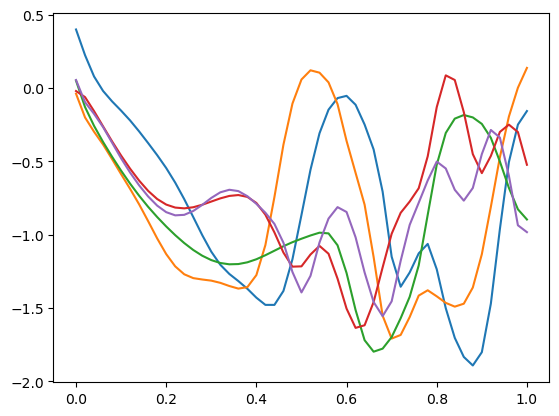

In [23]:
#Plot some of the data to visualize it
if Eqn_type == 'Burgers':
    for i in range(10):
        plt.plot(torch.linspace(0,1,8192),Data_a[i,:])
        plt.plot(torch.linspace(0,1,8192),Data_u[i,:])
else:
    for i in range(5):
        plt.plot(torch.linspace(0,1,Data_u.shape[-1]),Data_u[i,17,17,:])

In [24]:
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

In [25]:
if Eqn_type == 'Burgers':
    for i in range(1000):
        Data_i0 = Data_a[i:i+1,:].unsqueeze(-1)
        Data_i1 = Data_u[i:i+1,:].unsqueeze(-1)
        if i == 0:
            Data = torch.cat([Data_i0,Data_i1],-1)
        else:
            Data = torch.cat([Data,torch.cat([Data_i0,Data_i1],-1)])
        
    
else:
    Data = Data_u[:1000,:,:,:]

In [26]:
Data = Data.to(device)

In [27]:
Data = Data.float()

In [28]:
ids = np.tile(np.linspace(0,Data.shape[1]-1,num=n_points, dtype=np.int64),(Data.shape[1],1))

In [29]:
ids[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [30]:
t_ids = np.tile(np.linspace(0,Data.shape[-1]-1,num=args.time_points, dtype=np.int64),(Data.shape[-1],1))

In [31]:
t_ids[0]

array([ 0,  5, 11, 16, 22, 27, 33, 38, 44, 50])

In [32]:
ts_integration = torch.linspace(0,1,Data.shape[-1])
ts_integration = ts_integration[t_ids[0]]
print(ts_integration)
args.ts_integration = ts_integration

tensor([0.0000, 0.1000, 0.2200, 0.3200, 0.4400, 0.5400, 0.6600, 0.7600, 0.8800,
        1.0000])


In [33]:
if Eqn_type=='Burgers':
    Data = Data[:,ids[0],:]
else:
    Data = Data[:,ids[0],:,:]
    Data = Data[:,:,ids[0],:]
    Data = Data[:,:,:,t_ids[0]]
    #Data = Data[:,:,:,:args.time_points]

In [34]:
Data.shape

torch.Size([1000, 64, 64, 10])

In [35]:
args.range_imshow = np.array([np.quantile(to_np(Data).flatten(), 0.15), np.quantile(to_np(Data).flatten(), 0.85)])#np.array([-0.25,0.05])


In [36]:
args.range_imshow

array([-0.95369303,  0.95400238])

In [37]:

n_steps = 100#5000 
print('Data.shape: ',Data.shape)


Data_splitting_indices = Train_val_split(np.copy(index_np),0)
Train_Data_indices = Data_splitting_indices.train_IDs()
Val_Data_indices = Data_splitting_indices.val_IDs()
print('\nlen(Train_Data_indices): ',len(Train_Data_indices))
print('Train_Data_indices: ',Train_Data_indices)
print('\nlen(Val_Data_indices): ',len(Val_Data_indices))
print('Val_Data_indices: ',Val_Data_indices)
Dataset = Dynamics_Dataset(Data,times)

Dataset_all = Test_Dynamics_Dataset(Data,times)

# For the sampler
train_sampler = SubsetRandomSampler(Train_Data_indices)
valid_sampler = SubsetRandomSampler(Val_Data_indices)
    

dataloaders = {'train': torch.utils.data.DataLoader(Dataset, sampler=train_sampler, batch_size = args.batch_size, drop_last=True),
               'val': torch.utils.data.DataLoader(Dataset, sampler=valid_sampler, batch_size = args.batch_size, drop_last=True),
               'test': torch.utils.data.DataLoader(Dataset_all, batch_size = len(np.copy(index_np))),
              }

model = model_blocks(args.dim+2,
                     args.dim_emb,
                     args.n_head,
                     args.n_blocks,
                     args.n_ff,
                     args.attention_type,
                     args.dim_out,
                     args.final_block,
                     dropout=0.1)

if torch.cuda.is_available():
    model = model.cuda()

Data.shape:  torch.Size([1000, 64, 64, 10])

len(Train_Data_indices):  64
Train_Data_indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]

len(Val_Data_indices):  0
Val_Data_indices:  []


In [38]:
exp_mode = 'Fredholm'

In [39]:
#Fredholm mode
mask = None

In [40]:
#Volterra mode
if exp_mode == 'Volterra':
    masking_map =  masking_function(lambda x: 0.,lambda x: x,n_batch=1)
    mask_times = times
    mask = masking_map.create_mask(mask_times)

In [41]:
print(mask)

None


In [42]:
args.n_patch = 8 

In [43]:
Encoder = kernels.SingleConvNeuralNet(
    1,
    args.dim,
    args.dim,
    K=[4,4],
    S=[4,4]
)

In [44]:
if torch.cuda.is_available():
    Encoder = Encoder.cuda()

In [45]:
args.shapes = Encoder(Data[:4,...,:1].permute(0,3,1,2)).shape

In [46]:
args.shapes

torch.Size([4, 32, 16, 16])

In [47]:
args.n_points= args.shapes[-1]

In [48]:
Decoder = kernels.Decoder_NN_2D(args.shapes[-2]*args.shapes[-1]*args.dim,64**2,[64,128])

In [49]:
if torch.cuda.is_available():
    Decoder = Decoder.cuda()

In [50]:
args.epochs= 5000

In [51]:
args.eqn_type = Eqn_type

In [52]:
Full_experiment_AttentionalIE_PDE_Navier_Stokes(model,Encoder,Decoder,Data, times, index_np, mask, times, args, extrapolation_points=None)

/gpfs/gibbs/project/dijk/eaz29/conda_envs/notebook_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading  nie/Navier-Stokes_patch-8/run140/model
Running in evaluation mode


  0%|          | 0/32 [00:00<?, ?it/s]/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 2
  warnings.warn(
  6%|▋         | 2/32 [00:00<00:02, 11.34it/s]/gpfs/gibbs/project/dijk/eaz29/IE_source/Attentional_IE_solver.py:1461: UserWarning: Error increased on iteration 0
  

[0.01080311182886362, 0.01046496257185936, 0.009786410257220268, 0.011140613816678524, 0.010664599016308784, 0.010370398871600628, 0.010238110087811947, 0.009849325753748417, 0.010563929565250874, 0.0099965063855052, 0.010226413607597351, 0.010553858242928982, 0.010550609789788723, 0.01087271235883236, 0.010738104581832886, 0.009769119322299957, 0.009802601300179958, 0.01033147145062685, 0.010417952202260494, 0.01054841186851263, 0.010586264543235302, 0.010453936643898487, 0.010548582300543785, 0.010039560496807098, 0.010433502495288849, 0.03948180004954338, 0.030601724982261658, 0.03358140587806702, 0.03580079227685928, 0.031197233125567436, 0.0345294363796711, 0.044389758259058]
Average loss:  0.016298663049936296
std:  tensor(0.0108)
